# GA Analytics
## Feature Engineering, Pre-processing, and Modelling
### Blaine Murphy -- September 2021


For the feature engineering phase I will do the following.
- Read in the data exported from the EDA notebook
- Encode categorical features identified in EDA
- Condense data to user level
    - to help answer the business question for identifying big spenders and how to market to them
    - compute the target -- ln(total_user_revenue+1)
    - Calculate user level features with summary statistics for numeric features
- Split data into train, validation, and test for modelling
- Scale the data based on the training data
- Export data sets prepped for modelling

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')
os.listdir()

['e390021b-3cdc-4df0-b92e-22082e3ad15b_Data.csv',
 'GA_Test.npz',
 'GA_Train.npz',
 'GA_Validation.npz',
 'GDP by Country world bank.csv',
 'life expectency by country_world bank.csv',
 'Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Country_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Country_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'Metadata_Indicator_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_2763936.csv',
 'Metadata_Indicator_API_SP.DYN.LE00.IN_DS2_en_csv_v2_2764094.csv',
 'Metadata_Indicator_API_SP.POP.TOTL_DS2_en_csv_v2_2763937.csv',
 'Population by country world bank.csv',
 'sample_submission.csv',
 'sample_submission_v2.csv',
 'test.csv',
 'test_v2.csv',
 'train.csv',
 'train_eda.csv',
 'train_v2.csv',
 'train_wrangled.csv',
 'user_train_X.csv',
 'user_train_y.csv',
 'worldpopulationreview.com']

In [3]:
train = pd.read_csv('train_eda.csv',index_col=0,parse_dates=['date','dateTime'])
train.info()

C:\Users\blain\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 50 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

A couple of columns to fix. `keyword` is mostly null and I already created new columns from it based on the most frequent search words that resulted in a purchase.  I can drop it now.  

And `timeDiffLastVisit` is mostly null because most of the records are new visits, not repeat visits.  I will fill all of those nulls with the maximum of the `timeDiffLastVisit` column.


In [4]:
train.drop('keyword',axis=1,inplace=True)
train['timeDiffLastVisit'] = train.timeDiffLastVisit.fillna(train.timeDiffLastVisit.max())


In [5]:
### Convert to float for summary statistics below
train['hits'] = train['hits'].astype('float')
train['pageviews'] = train['pageviews'].astype('float')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 901907 entries, 0 to 903652
Data columns (total 49 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   channelGrouping                          901907 non-null  object        
 1   date                                     901907 non-null  datetime64[ns]
 2   fullVisitorId                            901907 non-null  object        
 3   sessionId                                901907 non-null  object        
 4   visitId                                  901907 non-null  int64         
 5   visitNumber                              901907 non-null  int64         
 6   visitStartTime                           901907 non-null  int64         
 7   browser                                  901907 non-null  object        
 8   operatingSystem                          901907 non-null  object        
 9   isMobile                  

### One hot encoding of categorical columns

In [7]:
"','".join(list(train.columns))

"channelGrouping','date','fullVisitorId','sessionId','visitId','visitNumber','visitStartTime','browser','operatingSystem','isMobile','deviceCategory','continent','subContinent','country','region','metro','city','campaign','source','hits','pageviews','bounces','newVisits','transactionRevenue','dollars','purchase','dateTime','hour','weekend','month','time','timeDiffLastVisit','countryPopulation','countryGDP','countryLE','state','keywordStore','keywordMerch','keywordShirt','keywordGoogle','keywordYoutube','keywordShop','keywordApparel','keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)','keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search"

In [8]:
num_cols = ['fullVisitorId','visitNumber','isMobile','hits','pageviews','bounces','newVisits',\
        'hour','weekend','time','timeDiffLastVisit',\
        'countryPopulation','countryGDP','countryLE','keywordStore',\
        'keywordMerch','keywordShirt','keywordGoogle',\
        'keywordYoutube','keywordShop','keywordApparel',\
        'keyword_(Remarketing/Content targeting)',\
        'keyword_(User vertical targeting)','keyword_(automatic matching)',\
        'keyword_(content targeting)','keyword_(not provided)','keyword_search',\
        'dollars','transactionRevenue']

In [9]:
dummy_cols = ['channelGrouping','browser','operatingSystem',\
              'deviceCategory','subContinent','city','state',\
              'campaign','source','month']

In [10]:
### convert month to object for label encoding
train['month'] = train['month'].astype('object')
train['month'].dtype

dtype('O')

In [11]:
train = pd.concat([train[num_cols],pd.get_dummies(train[dummy_cols])], axis=1)

In [12]:
train.shape

(901907, 319)

In [13]:
train_cols = list(train.columns)

### Grouping by user

In [14]:
bool_cols = ['isMobile','weekend','bounces','keywordStore','keywordMerch','keywordShirt',\
             'keywordGoogle','keywordYoutube','keywordShop','keywordApparel',\
             'keyword_(Remarketing/Content targeting)','keyword_(User vertical targeting)',\
             'keyword_(automatic matching)','keyword_(content targeting)','keyword_(not provided)','keyword_search' ]

In [15]:
user_groupby = train.groupby('fullVisitorId', as_index=True)

Creation of target

In [16]:
### Function for creation of target column ln(total_revenue_per_user + 1)
TargetFunc = lambda x: np.log(sum(x) + 1.0)


In [17]:
### Calculate target
X = user_groupby[['transactionRevenue']].agg(TargetFunc)

### Create number of visits
X['visits'] = user_groupby[['transactionRevenue']].count()

### Create statistical measures of numerical columns
for col in ['hits','pageviews','time']:
    dum = user_groupby[[col]].agg(['min','max','median','mean','std'])
    dum.columns = [col+i.capitalize() for i in ['min','max','median','mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum

    
for col in ['countryPopulation','countryGDP','countryLE']:
    dum = user_groupby[[col]].agg(['mean','std'])
    dum.columns = [col+i.capitalize() for i in ['mean','std']]
    X = pd.concat([X,dum], axis=1)
    del dum
    
### calculate mean of boolean columns
for col in bool_cols:
    dum = user_groupby[[col]].mean()
    dum.columns = [col+'Mean']
    X = pd.concat([X,dum], axis=1)
    del dum

### Mean of dummy columns with correct column naming
for col in dummy_cols:
    for dumi_col in [i for i in train_cols if i.startswith(col)]:
        dum = user_groupby[[dumi_col]].mean()
        dum.columns = [dumi_col+'Mean']
        X = pd.concat([X,dum], axis=1)
        del dum
    


    
X.head()

,transactionRevenue,visits,hitsMin,hitsMax,hitsMedian,hitsMean,hitsStd,pageviewsMin,pageviewsMax,pageviewsMedian,...,month_3Mean,month_4Mean,month_5Mean,month_6Mean,month_7Mean,month_8Mean,month_9Mean,month_10Mean,month_11Mean,month_12Mean
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
4823595352351,0.0,1,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5103959234087,0.0,1,10.0,10.0,10.0,10.0,NaN,8.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10278554503158,0.0,1,11.0,11.0,11.0,11.0,NaN,8.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20424342248747,0.0,1,17.0,17.0,17.0,17.0,NaN,13.0,13.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26722803385797,0.0,1,3.0,3.0,3.0,3.0,NaN,2.0,2.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
x_cols = X.columns

In [19]:
nulls = X.isna().sum().T
nulls[nulls>0]

hitsStd                 631804
pageviewsStd            631804
timeStd                 631804
countryPopulationStd    631804
countryGDPStd           631804
countryLEStd            631804
dtype: int64

In [20]:
X = X.fillna(0)

In [21]:
del train

In [22]:
y = X.pop('transactionRevenue')

In [23]:
X.shape

(722668, 328)

In [24]:
random_seed = 33

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=random_seed)


In [26]:
print('Train features:', X_train.shape)
print('Train target:', y_train.shape)
print('Validation features:',X_val.shape)
print('Validation target:',y_val.shape)
print('Test features:',X_test.shape)
print('Test target:',y_test.shape)


Train features: (578134, 328)
Train target: (578134,)
Validation features: (72267, 328)
Validation target: (72267,)
Test features: (72267, 328)
Test target: (72267,)


In [27]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train, X_test, X_val = ss.transform(X_train), ss.transform(X_test), ss.transform(X_val)




In [28]:
np.savez('GA_Train', inputs=X_train, targets = y_train)
np.savez('GA_Validation', inputs=X_val, targets = y_val)
np.savez('GA_Test', inputs=X_test, targets = y_test)

Data saved.

In [29]:
print('Train Frac of purchasers:', np.sum(y_train > 1) / y_train.shape[0])
print('Validation Frac purchasers:', np.sum(y_val > 1) / y_val.shape[0])
print('Test Frac purchasers:', np.sum(y_test > 1) / y_test.shape[0])

Train Frac of purchasers: 0.014142050112949592
Validation Frac purchasers: 0.013408609738884969
Test Frac purchasers: 0.013740711528083357


## Modelling phase

### Linear Regression with Lasso to get a baseline model performance and quick look at feature importance

In [2]:
import numpy as np
import os 

os.chdir(r'D:\Springboard\Capstone 3 maybe\Google Analytics')

In [3]:
### Loading data
train = np.load('GA_Train.npz')
valid = np.load('GA_Validation.npz')
test = np.load('GA_Test.npz')


In [4]:
from sklearn.linear_model import Lasso
lass = Lasso()
lass.fit(train['inputs'], train['targets'])

Lasso()

In [5]:
from sklearn.metrics import mean_squared_error
print('Lasso Regression RMSE:\n{:.3f}'.format(np.sqrt(mean_squared_error(valid['targets'],lass.predict(valid['inputs'])))))


Lasso Regression RMSE:
2.052


In [6]:
print(lass.coef_)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0.  0.  0. -0. -0. -0.
 -0.  0. -0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0. -0.
 -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0.
  0.  0. -0.  0. -0.  0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0.
 -0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0. -0.  0. -0.
  0. -0.  0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0.
  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.
 -0.  0.  0. -0. -0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0. -0. -0. -0.
  0. -0.  0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0.
 -0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0

Due to the large number of users who didn't make a purchaes The model predicts nobody will make a purchase.  

### Moving on to deep learning with TensorFlow

In [7]:
### Declare some variables for modelling 

input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 64
batch_size = 200
epochs = 50


Model building

In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [10]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'],valid['targets']),
          verbose = 2)

Epoch 1/50
2891/2891 - 7s - loss: 3.0723 - root_mean_squared_error: 1.7528 - mean_absolute_error: 0.3838 - val_loss: 2.5932 - val_root_mean_squared_error: 1.6103 - val_mean_absolute_error: 0.3016
Epoch 2/50
2891/2891 - 5s - loss: 2.8187 - root_mean_squared_error: 1.6789 - mean_absolute_error: 0.3372 - val_loss: 2.5318 - val_root_mean_squared_error: 1.5912 - val_mean_absolute_error: 0.2778
Epoch 3/50
2891/2891 - 5s - loss: 2.7556 - root_mean_squared_error: 1.6600 - mean_absolute_error: 0.3249 - val_loss: 2.5161 - val_root_mean_squared_error: 1.5862 - val_mean_absolute_error: 0.2990
Epoch 4/50
2891/2891 - 6s - loss: 2.6946 - root_mean_squared_error: 1.6415 - mean_absolute_error: 0.3162 - val_loss: 2.4790 - val_root_mean_squared_error: 1.5745 - val_mean_absolute_error: 0.2796
Epoch 5/50
2891/2891 - 5s - loss: 2.6680 - root_mean_squared_error: 1.6334 - mean_absolute_error: 0.3136 - val_loss: 2.4366 - val_root_mean_squared_error: 1.5610 - val_mean_absolute_error: 0.2882
Epoch 6/50
2891/2891

In [14]:
import matplotlib.pyplot as plt
def PlotLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    

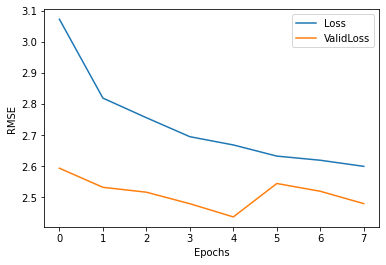

In [15]:
PlotLoss(history)

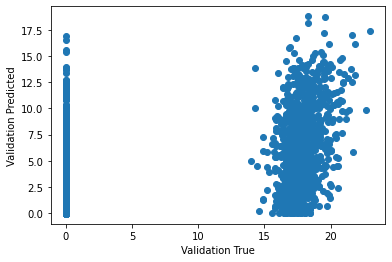

In [16]:
plt.scatter(valid['targets'],model.predict(valid['inputs']))
plt.xlabel('Validation True')
plt.ylabel('Validation Predicted')
plt.show()
            

The 3 layer NN does not do a good job of predicting user revenue.  As show before, only about 1% of the users made a purchase, which could be what's causing the poor results.  
___
Now I will try to create a NN model that predicts only whether a purchase was made. If that is succesful it could be an input into the regression model.  



In [25]:
train_purchase = 1.0 * np.array( [train['targets'] == 0, train['targets']>0] ).T
valid_purchase = 1.0 * np.array( [valid['targets'] ==0 , valid['targets'] > 0] ).T
test_purchase = 1.0 * np.array( [test['targets'] ==0 , test['targets'] > 0] ).T

In [18]:
### 
input_size = train['inputs'].shape[1]
output_size = 2
hidden_layer_size = 128
batch_size = 500
epochs = 50

In [19]:
clf_model = tf.keras.Sequential()
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dropout(.2))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dropout(.2))
clf_model.add(tf.keras.layers.Dense(hidden_layer_size,activation='relu'))
clf_model.add(tf.keras.layers.Dense(output_size,activation='softmax'))

clf_model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])




In [20]:
stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = clf_model.fit(train['inputs'],train_purchase,
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        callbacks=stop,                    
                        validation_data=(valid['inputs'],valid_purchase),
                        verbose=2
                       )                    

Epoch 1/50
1157/1157 - 6s - loss: 0.0388 - auc: 0.9975 - precision: 0.9852 - recall: 0.9852 - val_loss: 0.0274 - val_auc: 0.9984 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 2/50
1157/1157 - 5s - loss: 0.0293 - auc: 0.9983 - precision: 0.9877 - recall: 0.9877 - val_loss: 0.0276 - val_auc: 0.9986 - val_precision: 0.9888 - val_recall: 0.9888
Epoch 3/50
1157/1157 - 5s - loss: 0.0284 - auc: 0.9984 - precision: 0.9879 - recall: 0.9879 - val_loss: 0.0273 - val_auc: 0.9989 - val_precision: 0.9893 - val_recall: 0.9893
Epoch 4/50
1157/1157 - 6s - loss: 0.0276 - auc: 0.9985 - precision: 0.9880 - recall: 0.9880 - val_loss: 0.0266 - val_auc: 0.9987 - val_precision: 0.9892 - val_recall: 0.9892
Epoch 5/50
1157/1157 - 5s - loss: 0.0272 - auc: 0.9986 - precision: 0.9882 - recall: 0.9882 - val_loss: 0.0263 - val_auc: 0.9986 - val_precision: 0.9894 - val_recall: 0.9894
Epoch 6/50
1157/1157 - 5s - loss: 0.0268 - auc: 0.9987 - precision: 0.9884 - recall: 0.9884 - val_loss: 0.0272 - val_auc: 0.9988 -

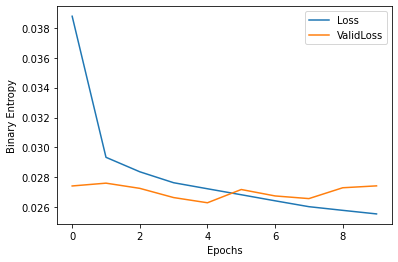

In [21]:
def PlotLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Entropy')
    plt.legend()
    plt.show()
    
PlotLoss(history)

In [61]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, confusion_matrix
train_predict_proba = clf_model.predict(train['inputs'])[:,1]
valid_predict_proba = clf_model.predict(valid['inputs'])[:,1]
test_predict_proba = clf_model.predict(test['inputs'])[:,1]

train_predicts = 1 * (train_predict_proba > 0.02)
valid_predicts = 1 * (valid_predict_proba > 0.02)

print('Train ROC AUC:', roc_auc_score(train_predicts ,train_predict_proba ))
print('Train Recall:',recall_score(train_purchase[:,1], train_predicts))
print('Train Precision:',precision_score(train_purchase[:,1], train_predicts))
print()
print('Validation ROC AUC:', roc_auc_score(valid_purchase[:,1], valid_predict_proba ))
print('Validation Recall:',recall_score(valid_purchase[:,1], valid_predicts))
print('Validation Precision:',precision_score(valid_purchase[:,1], valid_predicts))

Train ROC AUC: 1.0
Train Recall: 0.8738992172211351
Train Precision: 0.39116391109164567

Validation ROC AUC: 0.9889708831500433
Validation Recall: 0.8617131062951496
Validation Precision: 0.36881625441696114


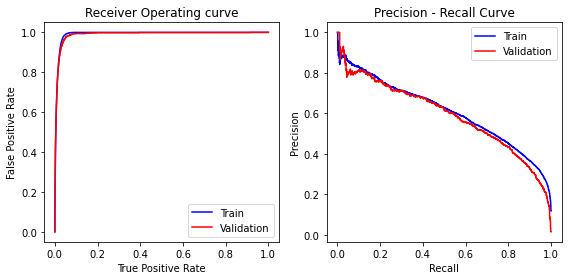

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve
fig,ax = plt.subplots(1,2, figsize = (8,4), tight_layout=True)

tpr, fpr, thresh = roc_curve(train_purchase[:,1], train_predict_proba)
ax[0].plot(tpr,fpr,c='blue')

tpr, fpr, thresh = roc_curve(valid_purchase[:,1], valid_predict_proba)
ax[0].plot(tpr,fpr,c='red')

ax[0].set_title('Receiver Operating curve')
ax[0].set_xlabel('True Positive Rate')
ax[0].set_ylabel('False Positive Rate')
ax[0].legend(labels=['Train','Validation'],loc='lower right')

p,r,t = precision_recall_curve(train_purchase[:,1], train_predict_proba)
ax[1].plot(r,p,c='blue')
p,r,t = precision_recall_curve(valid_purchase[:,1], valid_predict_proba)
ax[1].plot(r,p,c='red')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision - Recall Curve')
ax[1].legend(labels=['Train','Validation'])
plt.show()



These features are pretty good at predicting if there was a purchase, but I didn't take the final pre-processing steps that I normally would for a classification problem.  Quick check on the test set.

In [26]:
print('Test ROC AUC:', roc_auc_score(test_purchase[:,1], test_predict_proba ))

Test ROC AUC: 0.9886618711370763


Now how to use the predicted purchase in a regression model.  Is there a way to combine the classification and regression models into one? A model inside a model? For now I will concatenate the classification predicted probabilities to the inputs of the data sets, an create a new regression NN.

In [27]:
train['inputs'].shape

(578134, 328)

In [28]:
X_train = np.hstack([train['inputs'],train_predict_proba.reshape(-1,1)])

X_valid = np.hstack([valid['inputs'],valid_predict_proba.reshape(-1,1)])

X_test = np.hstack([test['inputs'],test_predict_proba.reshape(-1,1)])
print(X_train.shape)

(578134, 329)


Now going back to a tf regression modelling

In [29]:
input_size = X_train.shape[1]
output_size = 1
hidden_layer_size = 128
batch_size = 500
epochs = 50


In [30]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [31]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=X_train,
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid,valid['targets']),
          verbose = 2)

Epoch 1/50
1157/1157 - 3s - loss: 2.9918 - root_mean_squared_error: 1.7297 - mean_absolute_error: 0.3949 - val_loss: 2.4732 - val_root_mean_squared_error: 1.5726 - val_mean_absolute_error: 0.2957
Epoch 2/50
1157/1157 - 3s - loss: 2.7194 - root_mean_squared_error: 1.6490 - mean_absolute_error: 0.3300 - val_loss: 2.4178 - val_root_mean_squared_error: 1.5549 - val_mean_absolute_error: 0.2794
Epoch 3/50
1157/1157 - 4s - loss: 2.6506 - root_mean_squared_error: 1.6281 - mean_absolute_error: 0.3159 - val_loss: 2.4402 - val_root_mean_squared_error: 1.5621 - val_mean_absolute_error: 0.2815
Epoch 4/50
1157/1157 - 5s - loss: 2.5999 - root_mean_squared_error: 1.6124 - mean_absolute_error: 0.3023 - val_loss: 2.4699 - val_root_mean_squared_error: 1.5716 - val_mean_absolute_error: 0.2717
Epoch 5/50
1157/1157 - 4s - loss: 2.5885 - root_mean_squared_error: 1.6089 - mean_absolute_error: 0.2993 - val_loss: 2.5028 - val_root_mean_squared_error: 1.5820 - val_mean_absolute_error: 0.2749
Epoch 6/50
1157/1157

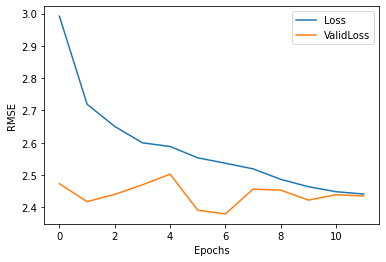

In [32]:
def PlotLoss(hist):
    plt.plot(hist.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='ValidLoss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    
PlotLoss(history)

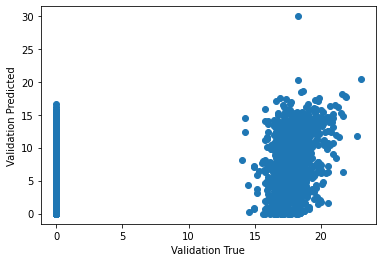

In [33]:
plt.scatter(valid['targets'],model.predict(X_valid))
plt.xlabel('Validation True')
plt.ylabel('Validation Predicted')
plt.show()

After using the classification probability prediction of purchase as an input into the regression NN the performance is pretty much the same as without it. I'll try again by using a threshold to transform the predicted probability into a prediction of purchase.

In [65]:
X_train = np.hstack([train['inputs'], (1. * (train_predict_proba>.02)).reshape(-1,1) ])

X_valid = np.hstack([valid['inputs'], (1. * (valid_predict_proba>.02)).reshape(-1,1)])

X_test = np.hstack([test['inputs'], (1. * (test_predict_proba>.02)).reshape(-1,1)])
print(X_train.shape)

(578134, 329)


In [66]:
input_size = X_train.shape[1]
output_size = 1
hidden_layer_size = 128
batch_size = 500
epochs = 50

In [67]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=X_train,
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(X_valid,valid['targets']),
          verbose = 2)

Epoch 1/50
1157/1157 - 3s - loss: 2.9833 - root_mean_squared_error: 1.7272 - mean_absolute_error: 0.4003 - val_loss: 2.5614 - val_root_mean_squared_error: 1.6004 - val_mean_absolute_error: 0.3003
Epoch 2/50
1157/1157 - 3s - loss: 2.7589 - root_mean_squared_error: 1.6610 - mean_absolute_error: 0.3330 - val_loss: 2.5130 - val_root_mean_squared_error: 1.5853 - val_mean_absolute_error: 0.3003
Epoch 3/50
1157/1157 - 4s - loss: 2.6850 - root_mean_squared_error: 1.6386 - mean_absolute_error: 0.3205 - val_loss: 2.4588 - val_root_mean_squared_error: 1.5681 - val_mean_absolute_error: 0.2887
Epoch 4/50
1157/1157 - 4s - loss: 2.6575 - root_mean_squared_error: 1.6302 - mean_absolute_error: 0.3149 - val_loss: 2.4991 - val_root_mean_squared_error: 1.5809 - val_mean_absolute_error: 0.2900
Epoch 5/50
1157/1157 - 4s - loss: 2.6009 - root_mean_squared_error: 1.6127 - mean_absolute_error: 0.3072 - val_loss: 2.4398 - val_root_mean_squared_error: 1.5620 - val_mean_absolute_error: 0.2894
Epoch 6/50
1157/1157

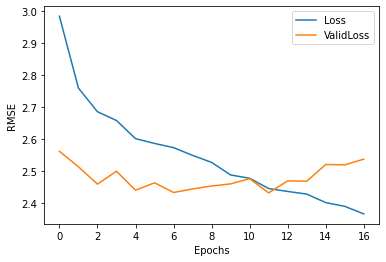

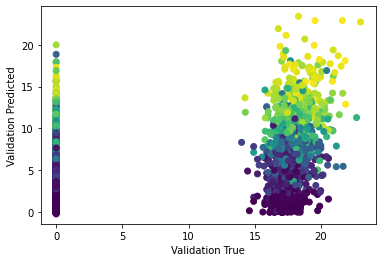

In [70]:
PlotLoss(history)

plt.scatter(valid['targets'],model.predict(X_valid), c=valid_predict_proba)
plt.xlabel('Validation True')
plt.ylabel('Validation Predicted')
plt.show()

(array([70816.,   387.,   228.,   130.,   101.,   115.,   135.,   136.,
          129.,    90.]),
 array([0.        , 0.09914807, 0.19829614, 0.29744422, 0.3965923 ,
        0.49574035, 0.59488845, 0.6940365 , 0.7931846 , 0.8923326 ,
        0.9914807 ], dtype=float32),
 <BarContainer object of 10 artists>)

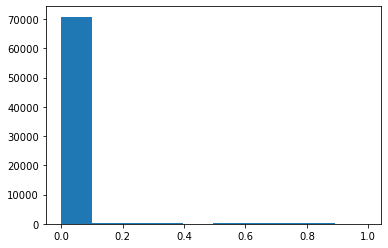

In [72]:
plt.hist(valid_predict_proba)

In [40]:
input_size = train['inputs'].shape[1]
output_size = 1
hidden_layer_size = 128
batch_size = 500
epochs = 50


In [41]:
model = tf.keras.Sequential()

### 3 Dense layers, first 2 with dropout for regularization
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(hidden_layer_size, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))




model.compile(optimizer='adam', 
              loss = tf.keras.losses.MeanSquaredError(), 
              metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

In [42]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(x=train['inputs'],
          y=train['targets'],
          batch_size=batch_size,
          callbacks=early_stop,
          epochs=epochs,
          validation_data=(valid['inputs'], valid['targets']),
          verbose = 2)

Epoch 1/50
1157/1157 - 6s - loss: 3.0458 - root_mean_squared_error: 1.7452 - mean_absolute_error: 0.4012 - val_loss: 2.7535 - val_root_mean_squared_error: 1.6594 - val_mean_absolute_error: 0.2954
Epoch 2/50
1157/1157 - 4s - loss: 2.7744 - root_mean_squared_error: 1.6657 - mean_absolute_error: 0.3353 - val_loss: 2.4533 - val_root_mean_squared_error: 1.5663 - val_mean_absolute_error: 0.2989
Epoch 3/50
1157/1157 - 5s - loss: 2.7118 - root_mean_squared_error: 1.6468 - mean_absolute_error: 0.3264 - val_loss: 2.4481 - val_root_mean_squared_error: 1.5646 - val_mean_absolute_error: 0.2818
Epoch 4/50
1157/1157 - 5s - loss: 2.6577 - root_mean_squared_error: 1.6302 - mean_absolute_error: 0.3146 - val_loss: 2.4413 - val_root_mean_squared_error: 1.5625 - val_mean_absolute_error: 0.2717
Epoch 5/50
1157/1157 - 5s - loss: 2.6341 - root_mean_squared_error: 1.6230 - mean_absolute_error: 0.3102 - val_loss: 2.4330 - val_root_mean_squared_error: 1.5598 - val_mean_absolute_error: 0.2700
Epoch 6/50
1157/1157

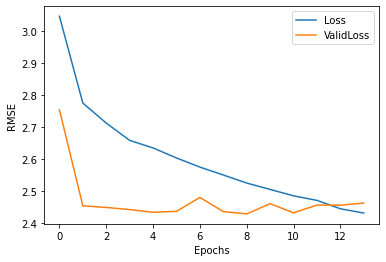

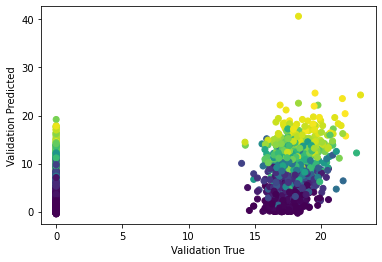

In [57]:
PlotLoss(history)

plt.scatter(valid['targets'],model.predict(valid['inputs']), c=valid_predict_proba)
plt.xlabel('Validation True')
plt.ylabel('Validation Predicted')
plt.show()

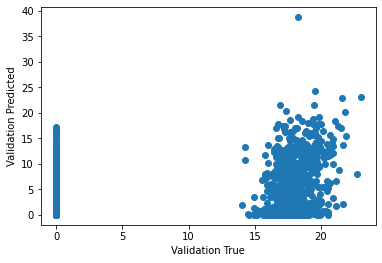

In [56]:
plt.scatter(valid['targets'], (valid_predict_proba * model.predict(valid['inputs']).T).T )
plt.xlabel('Validation True')
plt.ylabel('Validation Predicted')
plt.show()

In [48]:
model.predict(valid['inputs']).shape

(72267, 1)

In [49]:
valid_predict_proba.shape

(72267,)

In [54]:
(valid_predict_proba * model.predict(valid['inputs']).T).T.shape

(72267, 1)